# Generacja fraktali w Pythonie

## Importuję potrzebne biblioteki

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import polyfit
from tqdm import tqdm # optional

plt.rcParams['figure.figsize'] = [10, 10]

## Funkcje pomocnicze

Docelowo chciałbym zapisywać dany fraktal w formacie:
```python
sierpinski_nums = [
    [0.5, 0.0, 0.0, 0.5, 0.0, 0.0],
    [0.5, 0.0, 0.0, 0.5, 0.5, 0.0],
    [0.5, 0.0, 0.0, 0.5, 0.25, np.sqrt(3.)/4],
]

sierpinski_probs = [
    1./3,
    1./3,
    1./3,
]


```

gdzie pierwsza tablica opisuje przekształcenia (jak na wykładzie), a druga - odpowiednie prawdopodobieństwa.

Dla wydajności numerycznej, dobrze jest wykonywać transformacje jako mnożenie macierzy w numpy, z użyciem funkcji np.dot(W, x). 

Mam zatem funkcję konwertującą z podanego wyżej formatu, do macierzy obrotu i wektora przesunięcia.

Dla walorów edukacyjnych funkcje są opatrzone docstringami w formacie Google'a.

In [2]:
def generate_matrices(m):
    """
    Converts the fractal parameters to a matrix and a vector.
    
    Args:
        m: list of length 6, holds fractal params
        
    Returns:
        W: rotation matrix of the transformation
        b: translation vector of the transformation
    """
    W = np.array([[m[0], m[1]],
                  [m[2], m[3]]])
    
    b = np.array([m[4], m[5]], dtype=float)
    
    return W, b

Należy jednak pamiętać że każdy fraktal jest definiowany przez kilka takich zestawów parametrów. Dodaję więc funkcję która pozwala losowo, z zadanym rozkładem prawdopodobieństwa, wybrać jedną z list.

In [3]:
def get_random_params(m_list, probs):
    """
    Selects a random list from a list of lists, according to a distribution.
    
    Args:
        m_list: list of lists, contains the lists from which we want to choose
        probs: list of floats, such that sum(probs)==1, probability distribution over the lists
        
    Returns:
        W: randomly chosen rotation matrix of the transformation
        b: randomly chosen translation vector of the transformation
    
    """
    m = m_list[np.random.choice(range(len(m_list)), p=probs)]
    return generate_matrices(m)

## Definicja fraktali

Przykładowy fraktal, trójkąt Sierpińskiego:

In [4]:
sierpinski_nums = [
    [0.5, 0.0, 0.0, 0.5, 0.0, 0.0],
    [0.5, 0.0, 0.0, 0.5, 0.5, 0.0],
    [0.5, 0.0, 0.0, 0.5, 0.25, np.sqrt(3.)/4],
]

sierpinski_probs = [
    1./3,
    1./3,
    1./3,
]

sierpinski = (sierpinski_nums, sierpinski_probs)

Pozostałe fraktale importuję z zewnętrznego pliku, dla elegancji kodu.

In [5]:
from fractals import barnsley, dragon, levy

Wczytuję parametry wybranego fraktala:

In [6]:
m_list, probs = dragon
###probs = np.array(probs) # Check if necessary

## Generacja fraktala

Warunek początkowy: wektor (0, 0). Inicjalizuję również historię w której będę przechowywał kolejne położenia.

In [7]:
x = np.array([0, 0])
history = x.copy()

Wykonuję pewną liczbę kroków, gdzie w każdym kroku wybieram losową transformację. dokonuję obrotu i przesunięcia obecnego wektora położenia, i zapisuję nowe położenie w historii.

In [8]:
for step in tqdm(range(100000)):
    W, b = get_random_params(m_list, probs)
    x = np.dot(W, x) + b
    history = np.vstack((history, x))

100%|██████████| 100000/100000 [00:25<00:00, 3992.56it/s]


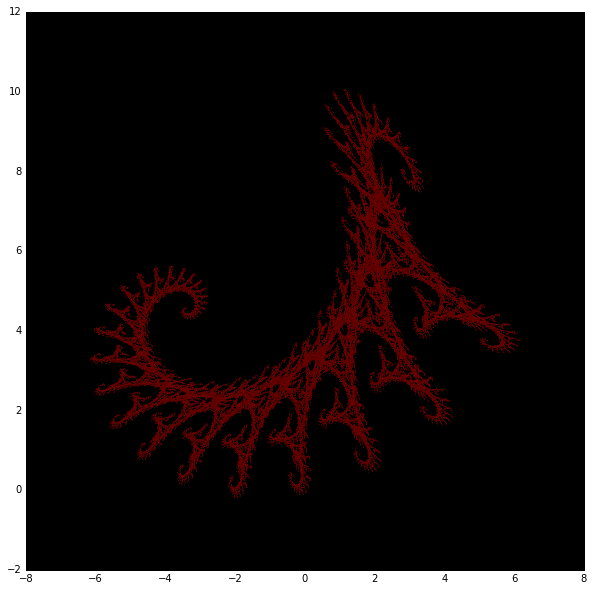

In [9]:
plt.rcParams['axes.facecolor'] = 'black'
plt.scatter(history[:, 0], history[:, 1], lw=0, s=.4, c='r')
plt.show()

Dla walorów estetycznych: sortuję historię "w pionie" i robię ładną mapę kolorów. Bo mogę.

In [10]:
hist_sort = history[np.argsort(history[:, 1])]
cmap = np.linspace(0, 1, history.shape[0])

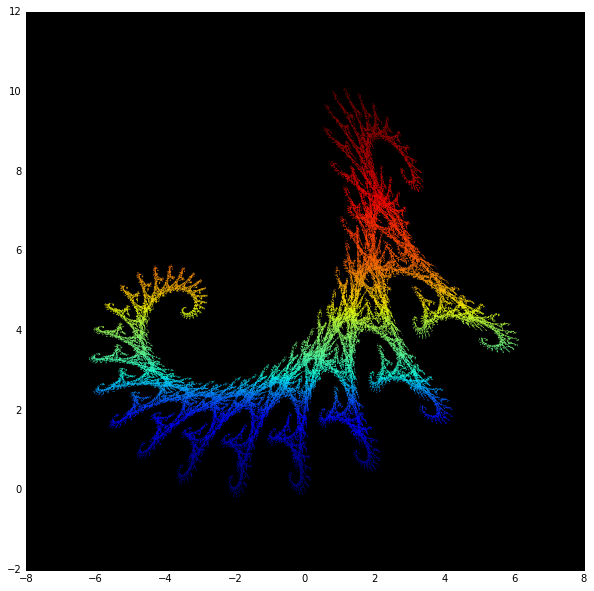

In [11]:
plt.rcParams['axes.facecolor'] = 'black'
plt.scatter(hist_sort[:, 0], hist_sort[:, 1], lw=0, s=.4, c=cmap)
plt.show()

## Wyznaczanie wymiaru fraktalnego

Wyznaczę teraz wymiar fraktalny wybranego fraktala, metodą "pudełkową". Na początek parę zmiennych pomocniczych.

In [12]:
xpoints, ypoints = history[:, 0], history[:, 1]
xmin, ymin = np.min(xpoints), np.min(ypoints)
xmax, ymax = np.max(xpoints), np.max(ypoints)

Chcę zmierzyć wymiar dla różnych podziałów pudełka, od $2^0$ do $2^{11}$. Korzystam ze sztuczki podanej na wykładzie, z ustawianiem wartości macierzy $2^r x 2^r$ zależnie od wartości punktów fraktala.

In [20]:
r_history = []
N_history = []
for r in tqdm(range(11)):
    box = np.zeros((2**r, 2**r))
    tabx = np.array((xpoints - xmin) / (xmax - xmin + 1e-8) * 2**r, dtype=int)
    taby = np.array((ypoints - ymin) / (ymax - ymin + 1e-8) * 2**r, dtype=int)

    box[tabx, taby] = 1
    
    r_history.append(r)
    N_history.append(box.sum())
    
r_history = np.array(r_history)
N_history = np.array(N_history)

100%|██████████| 11/11 [00:00<00:00, 125.10it/s]


### Dopasowanie

Przekształcam wielkości do skali logarytmicznej i obliczam najlepsze parametry dopasowania prostej.

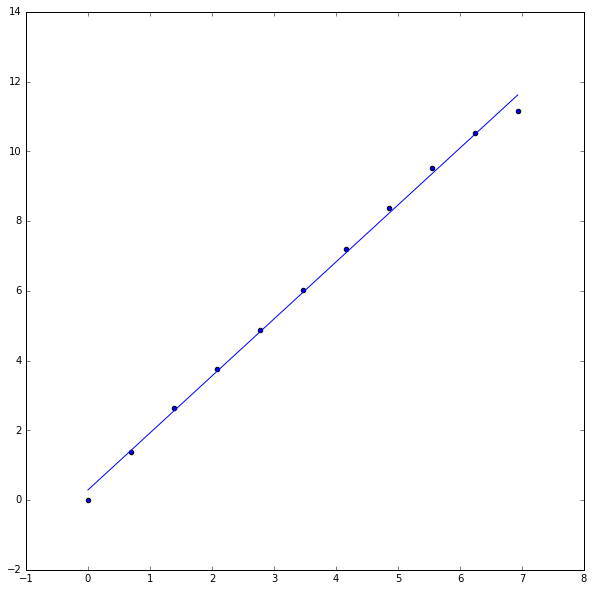

In [21]:
X = np.log(2) * r_history
Y = np.log(N_history)

a, b = polyfit(X, Y, 1)

plt.rcParams['axes.facecolor'] = 'white'

plt.scatter(X, Y)
plt.plot(X, a*X + b)
plt.show()

Współczynnik nachylenia prostej odpowiada wymiarowi fraktalnemu.

In [22]:
print(a)

1.63386967951
